<a href="https://colab.research.google.com/github/JaiswalFelipe/ITNPAI1_Assignment/blob/main/HPTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial imports and loading data

In [1]:
import tensorflow as tf
import random
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from keras import optimizers

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100 

In [2]:
# Load data, Train, val, test split
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

print("Training set size:", X_train.shape)
print("Validation set size:", X_valid.shape)
print("Testing set size:", X_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
Training set size: (45000, 32, 32, 3)
Validation set size: (5000, 32, 32, 3)
Testing set size: (10000, 32, 32, 3)


In [3]:
!pip install d2l==0.16.2 # Uncomment and run this if you are using Google Colab

     |████████████████████████████████| 77 kB 2.6 MB/s 


### Tuning

##### Tuning_1
- LR: ReduceLRonPlateau
- Epochs: 50
- Conv filters:
  - dense 14 reduced to half, 
  - final dense to 512
- Layers: 
  - Reduced to half
  - Added dropout layers (25%)

- loss: 1.0391 - accuracy: 0.6374 - val_loss: 1.2439 - val_accuracy: 0.6300
- test loss: 1.2393789291381836
test acc: 0.6187000274658203

In [ ]:
# VGG16 to VGG8
from keras.layers import BatchNormalization
def VGG8(classes=10): 
    
    img_input = Input(shape=(32,32,3)) 

    # Conv1
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) # 1. Active
    x = Dropout(0.25)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x)        # 2
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 1

    # Conv2
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 3 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 4
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 2

    # Conv3  
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 5 Active
    x = Dropout(0.25)(x)
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 6 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 7
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 3

    # Conv4
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 8 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 9
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 10
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 4

    # Conv5
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 11 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 12
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 13
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 5

    # FC
    x = Flatten()(x)
    x = Dense(1024, activation = 'relu')(x) # 14 Active, changed to 1024
    x = Dropout(0.5)(x)
    #x = Dense(4096, activation = 'relu')(x) # 15
    x = Dense(512, activation = 'relu')(x)   # 16 Active, changed to 512
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

modelVGG8 = VGG8(classes = 10)
modelVGG8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                             

In [ ]:
modelVGG8.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Sparse_categorical_crossentropy for loss

#Performance Scheduling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

# Reduced batch size 256 to 32
history_VGG8 = modelVGG8.fit(X_train, y_train, epochs=50,
        validation_data=(X_valid, y_valid),callbacks = [learning_rate_reduction],batch_size=32)

Epoch 1/50
1407/1407 [==============================] - 29s 10ms/step - loss: 2.0876 - accuracy: 0.2679 - val_loss: 1.9461 - val_accuracy: 0.3104 - lr: 0.0010
Epoch 2/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6635 - accuracy: 0.3842 - val_loss: 1.6848 - val_accuracy: 0.4132 - lr: 0.0010
Epoch 3/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5755 - accuracy: 0.4230 - val_loss: 1.6330 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 4/50
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5254 - accuracy: 0.4488 - val_loss: 1.6071 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 5/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5123 - accuracy: 0.4595 - val_loss: 1.5720 - val_accuracy: 0.4858 - lr: 0.0010
Epoch 6/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5030 - accuracy: 0.4684 - val_loss: 1.6188 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 7/50
1407/1407 [========================

In [ ]:
test_loss, test_acc = modelVGG8.evaluate(X_test,y_test)
print('test loss:', test_loss)
print('test acc:', test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 1.2394 - accuracy: 0.6187
test loss: 1.2393789291381836
test acc: 0.6187000274658203


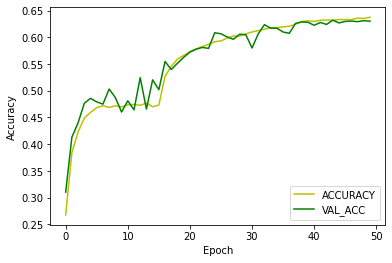

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_VGG8.history["accuracy"], 'y', label= 'ACCURACY')
plt.plot(history_VGG8.history["val_accuracy"], 'g', label= 'VAL_ACC')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

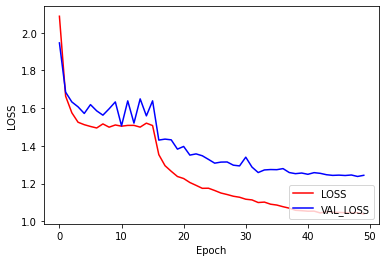

In [ ]:
plt.subplot(111)
plt.plot(history_VGG8.history['loss'], 'r', label= 'LOSS')
plt.plot(history_VGG8.history["val_loss"], 'b', label= 'VAL_LOSS')
#plt.plot(test_acc, 'r', label= 'TEST_ACC')
plt.ylabel("LOSS")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

##### Tuning_2: Maxpool to Avgpool
- loss: 0.5169 - accuracy: 0.8237 - val_loss: 0.6194 - val_accuracy: 0.7938
- test loss: 0.633486807346344
test acc: 0.7901999950408936

In [ ]:
# VGG16 to VGG8
from keras.layers import BatchNormalization
def VGG8avgp(classes=10): 
    
    img_input = Input(shape=(32,32,3)) 

    # Conv1
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) # 1. Active
    x = Dropout(0.25)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x)        # 2
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 1

    # Conv2
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 3 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 4
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 2

    # Conv3  
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 5 Active
    x = Dropout(0.25)(x)
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 6 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 7
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 3

    # Conv4
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 8 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 9
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 10
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 4

    # Conv5
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 11 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 12
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 13
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 5

    # FC
    x = Flatten()(x)
    x = Dense(1024, activation = 'relu')(x) # 14 Active, changed to 1024
    x = Dropout(0.5)(x)
    #x = Dense(4096, activation = 'relu')(x) # 15
    x = Dense(512, activation = 'relu')(x)   # 16 Active, changed to 512
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

modelVGG8avgp = VGG8avgp(classes = 10)
modelVGG8avgp.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 64)        0         
                                                           

In [ ]:
modelVGG8avgp.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Sparse_categorical_crossentropy for loss

#Performance Scheduling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

# Reduced batch size 256 to 32
history_VGG8avgp = modelVGG8avgp.fit(X_train, y_train, epochs=50,
        validation_data=(X_valid, y_valid),callbacks = [learning_rate_reduction],batch_size=32)

Epoch 1/50
1407/1407 [==============================] - 15s 10ms/step - loss: 1.8295 - accuracy: 0.2981 - val_loss: 1.5853 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 2/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4759 - accuracy: 0.4623 - val_loss: 1.3385 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 3/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3128 - accuracy: 0.5334 - val_loss: 1.1655 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 4/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2222 - accuracy: 0.5692 - val_loss: 1.0444 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 5/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1443 - accuracy: 0.6058 - val_loss: 1.0125 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 6/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1054 - accuracy: 0.6197 - val_loss: 1.0103 - val_accuracy: 0.6470 - lr: 0.0010
Epoch 7/50
1407/1407 [========================

In [ ]:
test_loss, test_acc = modelVGG8avgp.evaluate(X_test,y_test)
print('test loss:', test_loss)
print('test acc:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.7902
test loss: 0.633486807346344
test acc: 0.7901999950408936


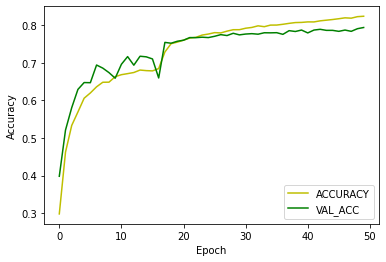

In [ ]:
plt.plot(history_VGG8avgp.history["accuracy"], 'y', label= 'ACCURACY')
plt.plot(history_VGG8avgp.history["val_accuracy"], 'g', label= 'VAL_ACC')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

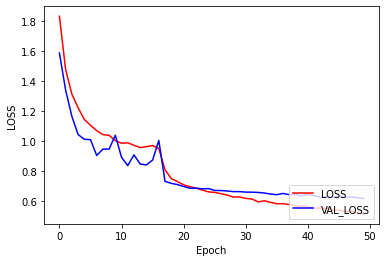

In [ ]:
plt.subplot(111)
plt.plot(history_VGG8avgp.history['loss'], 'r', label= 'LOSS')
plt.plot(history_VGG8avgp.history["val_loss"], 'b', label= 'VAL_LOSS')
#plt.plot(test_acc, 'r', label= 'TEST_ACC')
plt.ylabel("LOSS")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

##### Tuning_3: VGG6
- epoch: to 100
- filter size: change on dense, block 1,2 and 3
- pooling: Max


- loss: 0.1649 - accuracy: 0.9399 - val_loss: 0.5582 - val_accuracy: 0.8154
- test loss: 0.5780900716781616
test acc: 0.8120999932289124

In [ ]:
# VGG16 to VGG6
from keras.layers import BatchNormalization
def VGG6(classes=10): 
    
    img_input = Input(shape=(32,32,3)) 

    # Conv1
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) # 1 Active Input tensors
    x = Dropout(0.256)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x)        # 2 
    #x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 1

    # Conv2
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 3 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 4 
    #x = Dropout(0.25)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 2

    # Conv3  
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 5 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 6 
    #x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 7 
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 3

    # Conv4
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 8 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 9 
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 10 
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 4

    # Conv5
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 11 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 12 
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 13 
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 5

    # FC
    x = Flatten()(x)
    #x = Dense(4906, activation = 'relu')(x) # 14 
    #x = Dropout(0.5)(x)
    x = Dense(512, activation = 'relu')(x) # 15 Active
    #x = Dense(256, activation = 'relu')(x)   # 16 
    x = Dropout(0.256)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

modelVGG6 = VGG6(classes = 10)
modelVGG6.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 dropout_34 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 dropout_35 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                           

In [ ]:
modelVGG6.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Sparse_categorical_crossentropy for loss

#Performance Scheduling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

# Batch size 128
history_VGG6 = modelVGG6.fit(X_train, y_train, epochs=100,
        validation_data=(X_valid, y_valid),callbacks = [learning_rate_reduction],batch_size=128)

Epoch 1/100
352/352 [==============================] - 10s 25ms/step - loss: 3.5223 - accuracy: 0.3156 - val_loss: 1.9009 - val_accuracy: 0.3382 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 8s 23ms/step - loss: 1.5145 - accuracy: 0.4470 - val_loss: 1.7014 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 8s 23ms/step - loss: 1.3656 - accuracy: 0.5075 - val_loss: 1.5687 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 8s 23ms/step - loss: 1.2469 - accuracy: 0.5552 - val_loss: 1.4250 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 8s 23ms/step - loss: 1.1531 - accuracy: 0.5923 - val_loss: 1.3116 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 8s 23ms/step - loss: 1.0683 - accuracy: 0.6211 - val_loss: 1.2341 - val_accuracy: 0.6278 - lr: 0.0010
Epoch 7/100
352/352 [==============================] - 8s

In [ ]:
test_loss, test_acc = modelVGG6.evaluate(X_test,y_test)
print('test loss:', test_loss)
print('test acc:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.5781 - accuracy: 0.8121
test loss: 0.5780900716781616
test acc: 0.8120999932289124


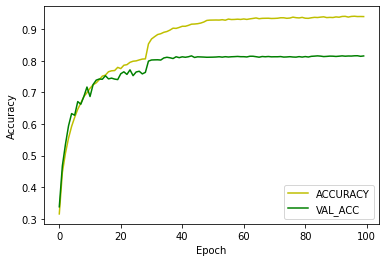

In [ ]:
plt.plot(history_VGG6.history["accuracy"], 'y', label= 'ACCURACY')
plt.plot(history_VGG6.history["val_accuracy"], 'g', label= 'VAL_ACC')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

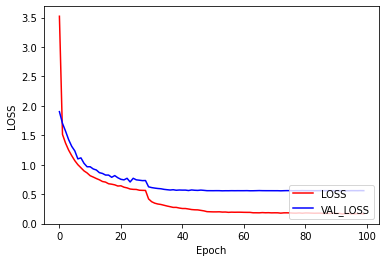

In [ ]:
plt.subplot(111)
plt.plot(history_VGG6.history['loss'], 'r', label= 'LOSS')
plt.plot(history_VGG6.history["val_loss"], 'b', label= 'VAL_LOSS')
#plt.plot(test_acc, 'r', label= 'TEST_ACC')
plt.ylabel("LOSS")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

#### Tuning4: VGG6 with Averagepool
- loss: 0.0900 - accuracy: 0.9684 - val_loss: 0.7183 - val_accuracy: 0.8386
- test loss: 0.7210038304328918
test acc: 0.8371999859809875

In [13]:
# VGG6 
def VGG6(classes=10): 
    
    img_input = Input(shape=(32,32,3)) 

    # Conv1
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) # 1 Active Input tensors
    x = Dropout(0.256)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x)        # 2 
    #x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 1

    # Conv2
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 3 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 4 
    #x = Dropout(0.25)(x)
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 2

    # Conv3  
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 5 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 6 
    #x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 7 
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 3

    # Conv4
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 8 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 9 
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 10 
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 4

    # Conv5
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 11 Active
    x = Dropout(0.25)(x)
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 12 
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 13 
    x = AveragePooling2D((2,2),strides=(2,2))(x) # maxpool 5

    # FC
    x = Flatten()(x)
    #x = Dense(4906, activation = 'relu')(x) # 14 
    #x = Dropout(0.5)(x)
    x = Dense(512, activation = 'relu')(x) # 15 Active
    #x = Dense(256, activation = 'relu')(x)   # 16 
    x = Dropout(0.256)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

modelVGG6 = VGG6(classes = 10)
modelVGG6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 dropout_14 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                           

In [14]:
modelVGG6.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Sparse_categorical_crossentropy for loss

#Performance Scheduling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

# Batch size 128
history_VGG6 = modelVGG6.fit(X_train, y_train, epochs=100,
        validation_data=(X_valid, y_valid),callbacks = [learning_rate_reduction], batch_size=128)

Epoch 1/100
352/352 [==============================] - 19s 50ms/step - loss: 1.7597 - accuracy: 0.3774 - val_loss: 1.3175 - val_accuracy: 0.5276 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 17s 48ms/step - loss: 1.2527 - accuracy: 0.5519 - val_loss: 1.0376 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 17s 48ms/step - loss: 1.0229 - accuracy: 0.6417 - val_loss: 0.8539 - val_accuracy: 0.7064 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 17s 48ms/step - loss: 0.8726 - accuracy: 0.6953 - val_loss: 0.7911 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 17s 48ms/step - loss: 0.7667 - accuracy: 0.7357 - val_loss: 0.7387 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 17s 48ms/step - loss: 0.6939 - accuracy: 0.7590 - val_loss: 0.7002 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 7/100
352/352 [==============================]

In [15]:
test_loss, test_acc = modelVGG6.evaluate(X_test,y_test)
print('test loss:', test_loss)
print('test acc:', test_acc)

313/313 [==============================] - 3s 9ms/step - loss: 0.7210 - accuracy: 0.8372
test loss: 0.7210038304328918
test acc: 0.8371999859809875


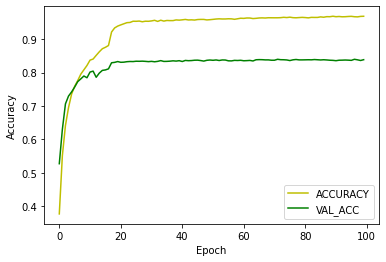

In [16]:
plt.plot(history_VGG6.history["accuracy"], 'y', label= 'ACCURACY')
plt.plot(history_VGG6.history["val_accuracy"], 'g', label= 'VAL_ACC')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

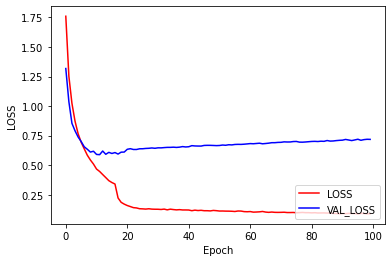

In [17]:
plt.subplot(111)
plt.plot(history_VGG6.history['loss'], 'r', label= 'LOSS')
plt.plot(history_VGG6.history["val_loss"], 'b', label= 'VAL_LOSS')
#plt.plot(test_acc, 'r', label= 'TEST_ACC')
plt.ylabel("LOSS")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

### Save best model

In [18]:
modelVGG6.save("VGG6_CIFAR10.h5")

### Load Model

airplane


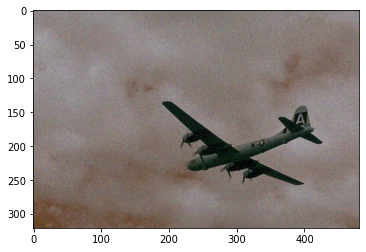

In [29]:
def prepare(filepath):
	img_size = 32
	img_array = cv2.imread(filepath)
	new_array = cv2.resize(img_array, (img_size, img_size))
	return new_array.reshape(-1, img_size, img_size , 3)

new_model = keras.models.load_model("/content/VGG6_CIFAR10.h5")  # Check under sample_data (drive)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']


test_predict = new_model.predict([prepare("/content/drive/MyDrive/Task-A-Dataset-denoising/noisy10/0000.png")])
print(classes[int(test_predict[0][0])])

img = cv2.imread("/content/drive/MyDrive/Task-A-Dataset-denoising/noisy10/0000.png")
plt.imshow(img)